In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

/Users/unger/dev/src/mountaineersdata/env/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
class FileCols(object):
	# Class holds information about a file.
	def __init__(self, allCols, dateCols, intCols, dropCols):
		self.allCols = allCols
		self.dateCols = dateCols
		self.intCols = intCols
		self.dropCols = dropCols

	@property 
	def colTypeMap(self):
		tm = {}
		for n in self.allCols:
			if not n in self.dateCols:
				if n in self.intCols:
					tm[n] = int
				else:
					tm[n] = str
		return tm

	@property
	def fixnaCols(self):
		# A list of columns where empty values should be changed to empty string
		return [ n for n in self.allCols if n not in self.dropCols and n not in self.dateCols ]

DataDirectory = Path(Path.home(), "Documents/mountaineers/kayak-seattle/data/paddleractivity")


#
# Column names.
#
C_FIRSTNAME = "First Name"
C_LASTNAME = "Last Name"
C_GRADUATIONDATE = "Graduation Date"
C_FULLNAME = "Full Name"
C_ACTIVITYTYPE = "Activity Type"
C_ACTIVITYSTARTDATE = "Activity Start Date"
C_ACTIVITYENDDATE = "Activity End Date"
C_ACTIVITYRESULT = "Activity Result"
C_ACTIVITYPARTICIPANTRESULT = "Activity Participant Result"
C_ACTIVITYCATEGORY = "Activity Category"
C_PADDLERTYPE = "Paddler Type"
C_TRIPCOUNT = "Trip Count"
C_COURSEPOSITION = "Course Position"

PT_BASIC = "Basic"
PT_EQUIVALENCY = "Equivalency"

# Course positions that represent graduation.
COURSEPOSITION_LIST = ["Graduate", "Equivalent"]

# Sea kayaking activity type.
AT_SEAKAYAKING = "Sea Kayaking"


# Define contents of our two data files
# Roster contains a roster of graduated students.
RosterFile = FileCols([ C_FIRSTNAME, C_LASTNAME, "Email", "Registration Status", C_COURSEPOSITION, C_GRADUATIONDATE ],
								[ C_GRADUATIONDATE] , [], [C_GRADUATIONDATE])
# Activity contains a list of graduate's subsequent activities
ActivityFile = FileCols([ C_FIRSTNAME, C_LASTNAME, "Email", "Course Title", "Activity Title", C_ACTIVITYCATEGORY, C_ACTIVITYTYPE, C_ACTIVITYSTARTDATE, C_ACTIVITYENDDATE, C_ACTIVITYRESULT, "Activity Participant Registration Status", C_ACTIVITYPARTICIPANTRESULT ],
								[C_ACTIVITYSTARTDATE, C_ACTIVITYENDDATE], [], [ C_ACTIVITYRESULT, C_ACTIVITYPARTICIPANTRESULT])

EquivRosterFileBase = "Seattle Equivalency"
EquivActivityFileBase = "Seattle Equivalency Activity"
EquivDates = [ 2015, 2016, 2021 ]

BasicRosterFileBase = "Seattle Basic"
BasicActivityFileBase = "Seattle Basic Activity"
BasicDates = [ 2015, 2016, 2017, 2018, 2019, 2021 ]

# Types of activities we count.  Exclude field trips, lectures, and seminars. 
ActivityCategoryList = [ "Trip", "Clinic" ]



In [3]:
def LoadData (dataDirectory, rosterFileBase, rosterCols: FileCols, activityFileBase, activityCols: FileCols, paddlerType, dateList, activityCategoryList):
	roster = None
	activity = None
	for date in dateList:
		#
		# Load the roster
		#
		fileName = f"{rosterFileBase} {date}.csv"
		filePath = Path(dataDirectory, fileName)
		ctm = rosterCols.colTypeMap
		r = pd.read_csv(filePath, usecols=rosterCols.allCols, parse_dates=rosterCols.dateCols, dtype=ctm)
		# Drop people who did not graduate
		r = r[r[C_COURSEPOSITION].isin(COURSEPOSITION_LIST)]

		# Fix columns that should contain empty string, not NaN and drop rows that still have NaN
		for n in rosterCols.fixnaCols:
			r[n].fillna('')
		r.dropna(inplace=True)

		if roster is None:
			roster = r
		else:
			roster = roster.append(r)


		#
		# Load the activity report
		#
		fileName = f"{activityFileBase} {date}.csv"
		filePath = Path(dataDirectory, fileName)
		a = pd.read_csv(filePath, usecols=activityCols.allCols, parse_dates=activityCols.dateCols, dtype=activityCols.colTypeMap)

		# Fix columns that should contain empty string, not NaN and drop rows that still have NaN
		for n in activityCols.fixnaCols:
			a[n].fillna('')
		a.dropna(inplace=True)

		# Limit to Sea Kayaking and specific activity category
		a = a[ (a[C_ACTIVITYTYPE] == AT_SEAKAYAKING) ]
		a = a[ a[C_ACTIVITYCATEGORY].isin(activityCategoryList) ]
		if activity is None:
			activity = a
		else:
			activity = activity.append(a)

	# Set paddler type and full name field for easier cross reference.
	roster[C_PADDLERTYPE] = paddlerType
	roster[C_FULLNAME] = roster[C_FIRSTNAME] + " " + roster[C_LASTNAME]
	activity[C_FULLNAME] = activity[C_FIRSTNAME] + " " + activity[C_LASTNAME]

	# Use full name as index.  	
	roster.set_index(C_FULLNAME, inplace=True)
	activity.set_index(C_FULLNAME, inplace=True)

	return (roster, activity)

(basicRoster, basicActivity) = LoadData(DataDirectory, BasicRosterFileBase, RosterFile, BasicActivityFileBase, ActivityFile, PT_BASIC, BasicDates, ActivityCategoryList)
#basicRoster.to_csv("BasicRoster.csv")
#basicActivity.to_csv("BasicActivity.csv")
(equivRoster, equivActivity) = LoadData(DataDirectory, EquivRosterFileBase, RosterFile, EquivActivityFileBase, ActivityFile, PT_EQUIVALENCY, EquivDates, ActivityCategoryList)
#equivRoster.to_csv("EquivRoster.csv")
#equivActivity.to_csv("EquivActivity.csv")
fullRoster = basicRoster.append(equivRoster)
fullActivity = basicActivity.append(equivActivity)
fullRoster.to_csv("fullRoster.csv")
fullActivity.to_csv("fullActivity.csv")



In [4]:
# Calculate trip counts for entries on roster
# Apply a lambda function on reach row.  
#   fullActivity.index == row.name
# returns an array of True, False for index matching name.  sum() calculates sum of those, counting True as 1 and False a 0
fullRoster[C_TRIPCOUNT] = fullRoster.apply(lambda row : sum(fullActivity.index == row.name), axis=1)

Text(0.5, 1.0, 'Number of Trips by Paddler')

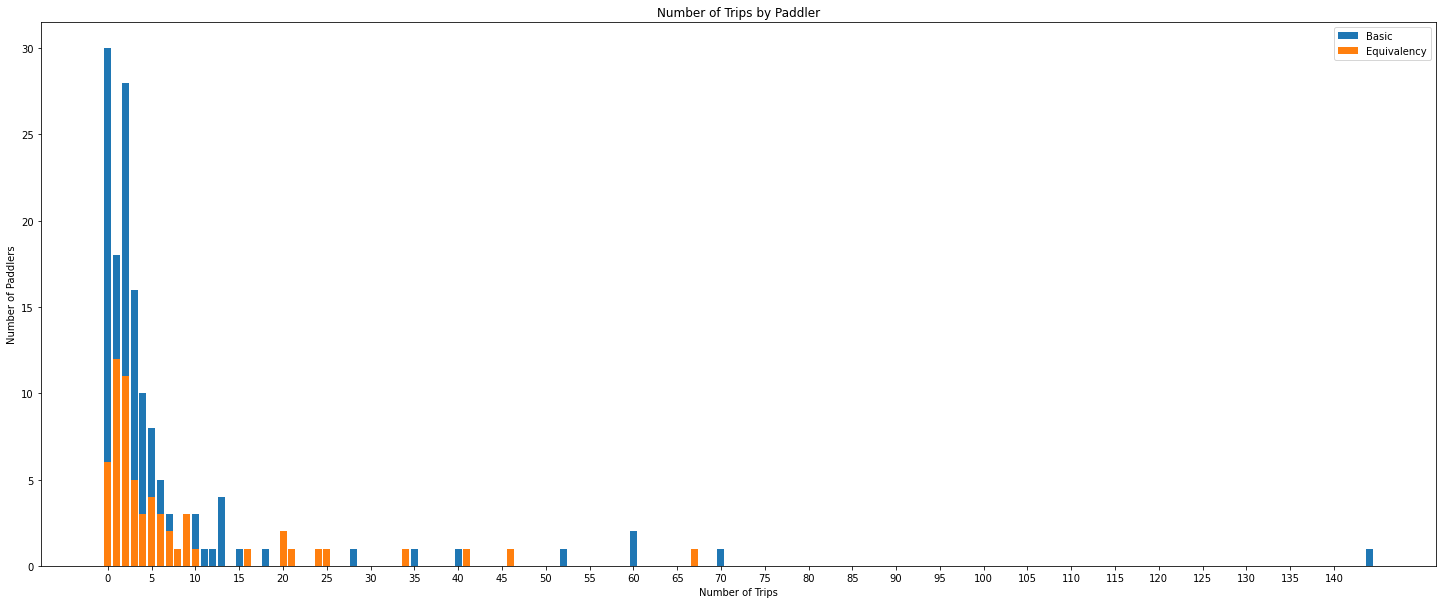

In [5]:
plt.figure(figsize=(25,10))

# Get trip count series for basic and equivalency paddlers
btc = fullRoster[fullRoster[C_PADDLERTYPE] == PT_BASIC][C_TRIPCOUNT]
etc = fullRoster[fullRoster[C_PADDLERTYPE] == PT_EQUIVALENCY][C_TRIPCOUNT]

b = max(btc.max(), btc.max())

# Graph the two
plt.hist(btc, bins=btc.max(), alpha=1.0, label=PT_BASIC, align='left', rwidth=0.8)
plt.hist(etc, bins=etc.max(), alpha=1.0, label=PT_EQUIVALENCY, align='left', rwidth=0.8)
plt.xlabel("Number of Trips")
plt.xticks(range(0,b,5))
plt.ylabel("Number of Paddlers")
plt.legend()
plt.title("Number of Trips by Paddler")


In [6]:
# Add grad year for easier grouping.
fullRoster["gradyear"] = fullRoster.apply(lambda row : row[C_GRADUATIONDATE].year, axis=1)
# Group by paddler type and grad year
# this givs us a two level grouping.  yg[PT_BASIC] is a series with index of years and value of number of graduates
#  yg[PT_BASIC].index and yg[PT_BASIC].values
yg = fullRoster.groupby([C_PADDLERTYPE, "gradyear"]).size()

# But there may be missing years (2020 no basic class).  To display both on one graph we need
# to align the data.  Do this by creating a new data frame with a column for basic and equivlency.
# Then fill NaN with zero graduates.
yd = pd.DataFrame({PT_BASIC: yg[PT_BASIC], PT_EQUIVALENCY: yg[PT_EQUIVALENCY]})
yd.fillna(0, inplace=True)

# Now we have a dataframe with number of graduates each year.

<BarContainer object of 7 artists>

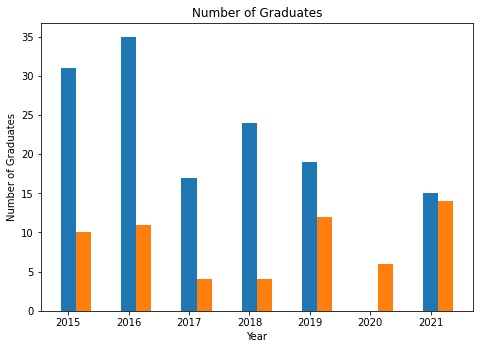

In [7]:
# Create array of length equal to the number of years
X = np.arange(len(yd))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Number of Graduates")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Graduates")
ax.bar(X, yd[PT_BASIC].values, tick_label=yd.index, width = 0.25, label=PT_BASIC)
ax.bar(X + 0.25, yd[PT_EQUIVALENCY].values,  width = 0.25, label=PT_EQUIVALENCY)
